# Prediction of Phylogenetic Kingdom from Codon Expression Patterns

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Additional data to support analysis: Codons and their full names
codon_key = pd.read_csv("codon_types.csv")
kingdom_names = pd.read_csv("kingdom_names.csv")

## Data Loading and Original Format

In [2]:
# Loading Data
data = pd.read_csv("codon_usage.csv", low_memory=False)\
    .join(kingdom_names.set_index("Kingdom"), on="Kingdom")\
    .drop("Kingdom", axis=1)\
    .rename({"Kingdom_full":"Kingdom"}, axis=1)
print(data.shape)

# Show dtypes
print(data.dtypes)

(13028, 69)
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
UUU             object
                ...   
GAG            float64
UAA            float64
UAG            float64
UGA            float64
Kingdom         object
Length: 69, dtype: object


In [3]:
# Showing the data
data.head()

,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,...,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA,Kingdom
0,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,...,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000,Virus
1,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,...,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000,Virus
2,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,...,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144,Virus
3,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,...,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000,Virus
4,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,...,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131,Virus


In [4]:
# Define input and output columns
x_cols = list(data.columns[[len(x) == 3 for x in data.columns]].values)
y_col = "Kingdom"
xy_cols = x_cols + [y_col]

## Descriptive Statistics and Data Preprocessing 

In [5]:
# Remove rows that have numeric characters in codon columns (probably data entry error)
data = data[~data['UUU'].str.contains('[A-Za-z]') & ~data['UUC'].str.contains('[A-Za-z]')]
data[["UUU","UUC"]] = data[["UUU","UUC"]].astype(float)

# Add extra column for the log of Ncodons 
data['log_Ncodons'] = list(np.log10(data.Ncodons.values))

# Data shape after dropping incorrect values
print(data.shape)

(13026, 70)


In [6]:
# There are no missing values
data.columns[data.isnull().sum() > 0]

Index([], dtype='object')

In [7]:
# Shape of original data
print("Shape of Dataset: ", data.shape)
print("Number of Input Columns: ", len(x_cols))
print("Data Types of Inputs: ", set(data[x_cols].dtypes))

Shape of Dataset:  (13026, 70)
Number of Input Columns:  64
Data Types of Inputs:  {dtype('float64')}


Text(0.5, 0.98, 'Number of Codons by Kingdom')

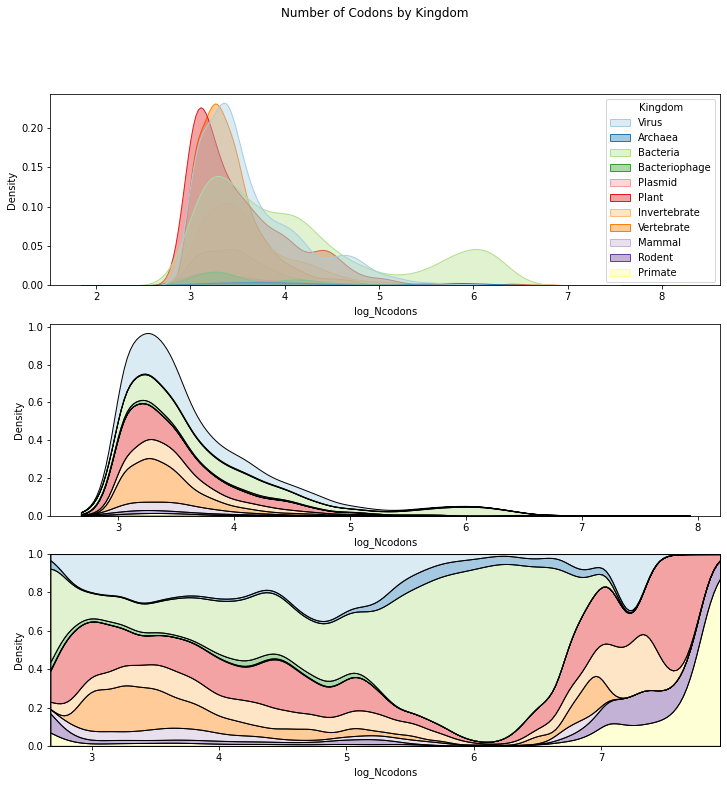

In [8]:
# [not used in analysis] Number of codons per kingdom

fig, ax = plt.subplots(3,1,figsize=(12, 12))

sns.kdeplot(data=data, x="log_Ncodons", 
            hue="Kingdom", alpha = 0.4, linewidth=1, fill=True,
           palette = "Paired",
           ax=ax[0])

sns.kdeplot(data=data, x="log_Ncodons", 
            hue="Kingdom", alpha = 0.4, linewidth=1, fill=True, multiple="stack",
           palette = "Paired",
           ax=ax[1])
sns.kdeplot(data=data, x="log_Ncodons", 
            hue="Kingdom", alpha = 0.4, linewidth=1, fill=True, multiple="fill",
           palette = "Paired",
           ax=ax[2])


ax[1].get_legend().remove()
ax[2].get_legend().remove()
fig.suptitle("Number of Codons by Kingdom")

In [9]:
# Long formatted data to make graphing easier
data_long = pd.melt(data[xy_cols], 
                    id_vars = "Kingdom", 
                    var_name = "codon", 
                    value_name = "freq")\
    .merge(codon_key, left_on='codon', right_on='Codon')

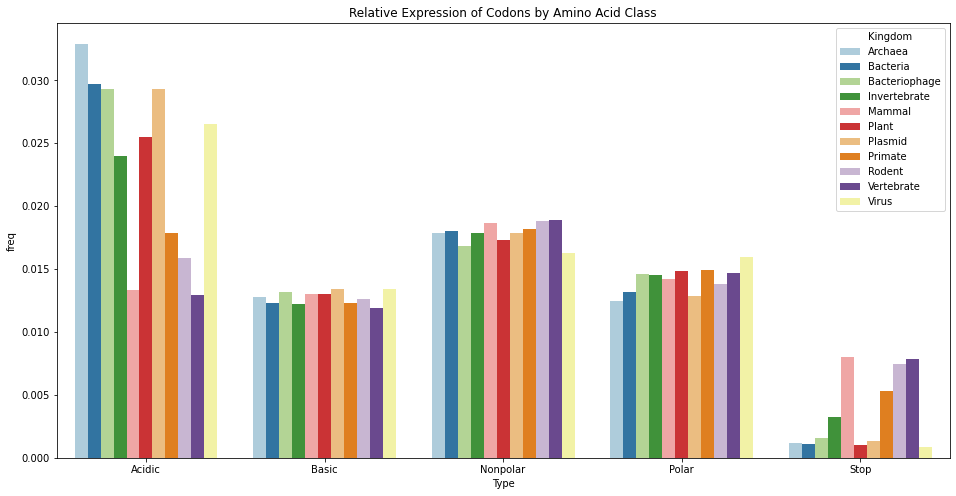

In [10]:
# Codon frequency by AA property
grouped_codon_freq = data_long[["Kingdom", "Type", "freq"]]\
    .groupby(["Kingdom", "Type"])\
    .mean()\
    .reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(x = "Type", y="freq", hue="Kingdom", data=grouped_codon_freq, palette = "Paired")\
    .set_title("Relative Expression of Codons by Amino Acid Class")
plt.show()

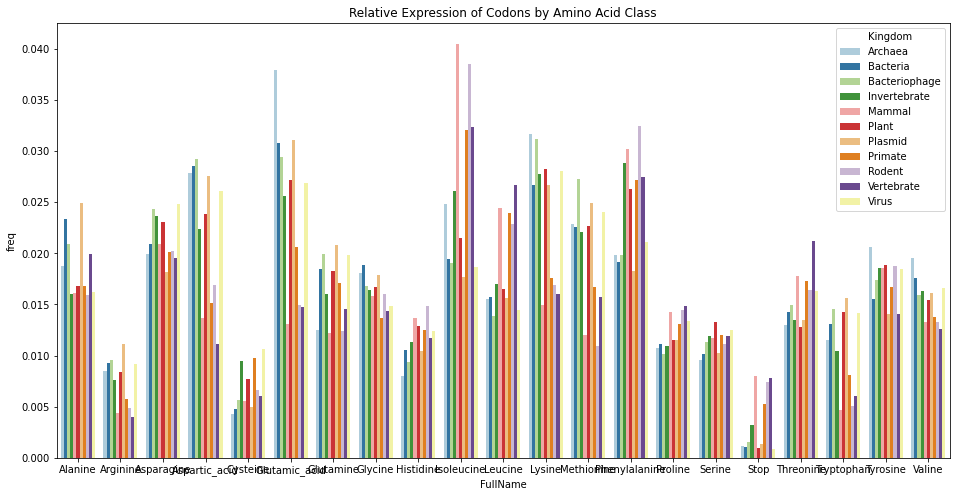

In [11]:
# [not used in analysis] Individual codon frequency
grouped_codon_freq = data_long[["Kingdom", "FullName", "freq"]]\
    .groupby(["Kingdom", "FullName"])\
    .mean()\
    .reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(x = "FullName", y="freq", hue="Kingdom", data=grouped_codon_freq, palette = "Paired")\
    .set_title("Relative Expression of Codons by Amino Acid Class")
plt.show()

## Handling Class Imbalances

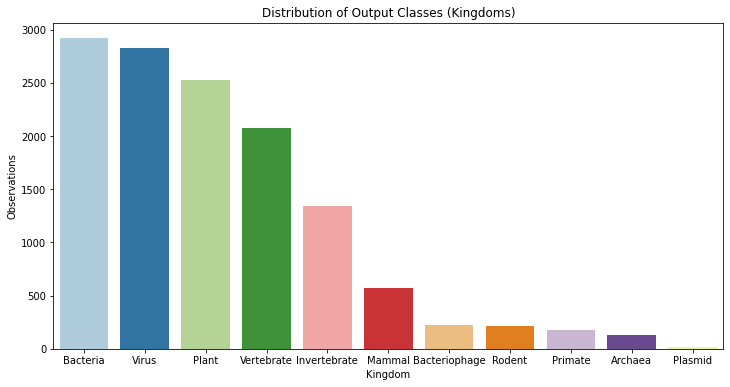

Post SMOTE Kingdom Distributions
Vertebrate       2919
Plant            2919
Mammal           2919
Bacteriophage    2919
Primate          2919
Virus            2919
Bacteria         2919
Invertebrate     2919
Rodent           2919
Archaea          2919
Plasmid          2919
Name: Kingdom, dtype: int64
(32109, 64)


In [12]:
# SMOTE
X = data[x_cols]
y = data[y_col]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Kingdom",
    y="Observations",
    data=y.value_counts().reset_index().rename({"index":"Kingdom", "Kingdom":"Observations"}, axis=1),
    palette="Paired"
).set_title("Distribution of Output Classes (Kingdoms)")
plt.show()
X, y = SMOTE().fit_resample(X, y)

print("Post SMOTE Kingdom Distributions")
print(y.value_counts())
print(X.shape)

## Data Splitting

In [13]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X.values, 
    y.values, 
    test_size=0.33, random_state=0)

print("Training Input Shape: ", X_train.shape)
print("Training Output Shape: ", y_train.shape)
print("Testing Input Shape: ", X_test.shape)
print("Testing Output Shape: ", y_test.shape)

Training Input Shape:  (21513, 64)
Training Output Shape:  (21513,)
Testing Input Shape:  (10596, 64)
Testing Output Shape:  (10596,)


## Modeling

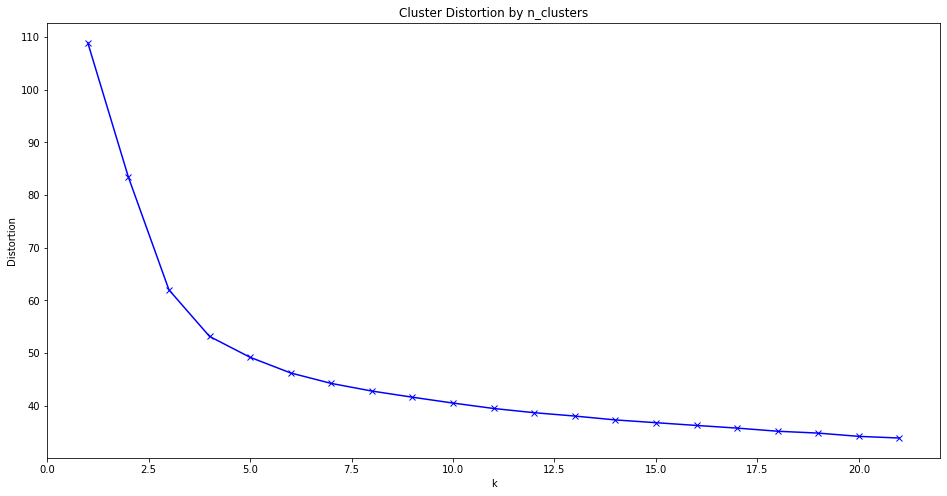

In [14]:
# [not used in analysis] Kmeans cluster plot for the total data to see correct cluster k
distortions = []
K = range(1,22)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(data[x_cols])
    distortions.append(km.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Cluster Distortion by n_clusters')
plt.show()

In [15]:
# [not used in analysis] Kmeans clusters for the total data 
km = KMeans(n_clusters=5, random_state=0).fit(data[x_cols])
data["clust4"] = km.predict(data[x_cols])

## Randomforest Modeling

In [16]:
# Base RF model and performance
rf_params = {
    'max_depth':[3,5,7,9],
    'n_estimators':[10,15,20,30]
}

rf_base = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=rf_params, 
    cv=5
)

rf_base.fit(X_train, y_train)

print(rf_base.best_params_)
train_pred_rf_base = rf_base.best_estimator_.predict(X_train)
test_pred_rf_base = rf_base.best_estimator_.predict(X_test)

print(classification_report(y_test, test_pred_rf_base))

{'max_depth': 9, 'n_estimators': 30}
               precision    recall  f1-score   support

      Archaea       0.96      0.99      0.98       953
     Bacteria       0.89      0.88      0.89       926
Bacteriophage       0.96      0.97      0.97       964
 Invertebrate       0.89      0.85      0.87       969
       Mammal       0.92      0.88      0.90       975
        Plant       0.87      0.85      0.86       976
      Plasmid       0.97      0.99      0.98       960
      Primate       0.89      0.94      0.92       964
       Rodent       0.94      0.94      0.94      1002
   Vertebrate       0.99      0.88      0.93       928
        Virus       0.82      0.91      0.86       979

     accuracy                           0.92     10596
    macro avg       0.92      0.92      0.92     10596
 weighted avg       0.92      0.92      0.92     10596



## KNN Modeling

In [17]:
# Base KNN model and performance
knn_base = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={'n_neighbors': list(range(2,6))}
)
knn_base.fit(X_train, y_train)

print(knn_base.best_params_)
train_pred_knn_base = knn_base.best_estimator_.predict(X_train)
test_pred_knn_base = knn_base.best_estimator_.predict(X_test)

print(classification_report(y_test, test_pred_knn_base))

{'n_neighbors': 2}
               precision    recall  f1-score   support

      Archaea       0.98      1.00      0.99       953
     Bacteria       0.95      0.92      0.94       926
Bacteriophage       0.97      0.99      0.98       964
 Invertebrate       0.92      0.98      0.95       969
       Mammal       0.99      1.00      0.99       975
        Plant       0.94      0.92      0.93       976
      Plasmid       0.97      1.00      0.99       960
      Primate       0.98      1.00      0.99       964
       Rodent       0.98      1.00      0.99      1002
   Vertebrate       1.00      0.95      0.97       928
        Virus       0.99      0.89      0.94       979

     accuracy                           0.97     10596
    macro avg       0.97      0.97      0.97     10596
 weighted avg       0.97      0.97      0.97     10596



## PCA Transformation

In [18]:
# Making the principal comoponents
data_pca = PCA(n_components=10).fit_transform(X)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    data_pca, 
    y.values, 
    test_size=0.33, random_state=0)

In [19]:
# Final data size of PCA inputs
print(data_pca.shape)

(32109, 10)


In [20]:
# Randomforest with PCA
rf_params = {
    'max_depth':[3,5,7,9],
    'n_estimators':[10,15,20,30]
}

rf_pca = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=rf_params, 
    cv=5
)

rf_pca.fit(X_pca_train, y_pca_train)

print(rf_pca.best_params_)
train_pred_rf_pca = rf_pca.best_estimator_.predict(X_pca_train)
test_pred_rf_pca = rf_pca.best_estimator_.predict(X_pca_test)

print(classification_report(y_pca_test, test_pred_rf_pca))

{'max_depth': 9, 'n_estimators': 30}
               precision    recall  f1-score   support

      Archaea       0.94      0.96      0.95       953
     Bacteria       0.83      0.77      0.80       926
Bacteriophage       0.91      0.87      0.89       964
 Invertebrate       0.79      0.76      0.77       969
       Mammal       0.78      0.70      0.74       975
        Plant       0.81      0.78      0.79       976
      Plasmid       0.91      0.99      0.95       960
      Primate       0.81      0.88      0.84       964
       Rodent       0.78      0.82      0.80      1002
   Vertebrate       0.93      0.80      0.86       928
        Virus       0.73      0.84      0.78       979

     accuracy                           0.83     10596
    macro avg       0.84      0.83      0.83     10596
 weighted avg       0.84      0.83      0.83     10596



In [21]:
# KNN with PCA
knn_pca = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={'n_neighbors': list(range(2,6))}
)
knn_pca.fit(X_pca_train, y_pca_train)

print(knn_pca.best_params_)
train_pred_knn_pca = knn_pca.best_estimator_.predict(X_pca_train)
test_pred_knn_pca = knn_pca.best_estimator_.predict(X_pca_test)

print(classification_report(y_pca_test, test_pred_knn_pca))

{'n_neighbors': 2}
               precision    recall  f1-score   support

      Archaea       0.96      1.00      0.98       953
     Bacteria       0.90      0.88      0.89       926
Bacteriophage       0.94      0.99      0.97       964
 Invertebrate       0.83      0.93      0.88       969
       Mammal       0.95      0.98      0.96       975
        Plant       0.90      0.84      0.87       976
      Plasmid       0.97      1.00      0.99       960
      Primate       0.96      0.99      0.98       964
       Rodent       0.97      0.99      0.98      1002
   Vertebrate       0.98      0.90      0.94       928
        Virus       0.95      0.81      0.87       979

     accuracy                           0.94     10596
    macro avg       0.94      0.94      0.94     10596
 weighted avg       0.94      0.94      0.94     10596



Performing KMeans on Codons Producing Stop Amino Acids.


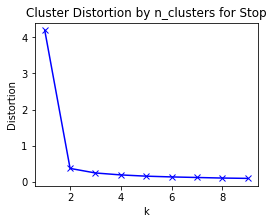

Select n_clusters from graph. 2
Performing KMeans on Codons Producing Polar Amino Acids.


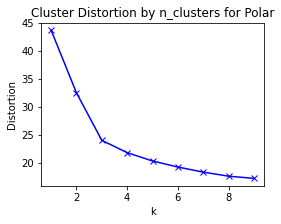

Select n_clusters from graph. 3
Performing KMeans on Codons Producing Acidic Amino Acids.


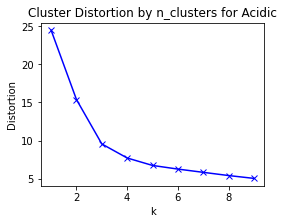

Select n_clusters from graph. 3
Performing KMeans on Codons Producing Nonpolar Amino Acids.


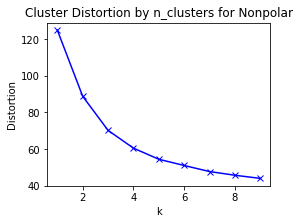

Select n_clusters from graph. 4
Performing KMeans on Codons Producing Basic Amino Acids.


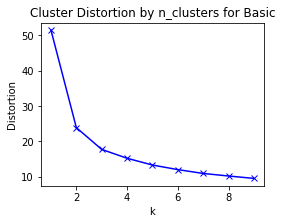

Select n_clusters from graph. 3


In [22]:
# Creating codong groups by looping through AA type and clustering each

# Create empty list to hold results
aa_type_data = np.array([])

# Loop through all amino acid types
for aa_type in set(codon_key.Type):
    print("Performing KMeans on Codons Producing " + aa_type + " Amino Acids.")
    
    # Get the subset of data for the current AA type
    cod = codon_key[codon_key.Type == aa_type].Codon.values
    cod_df = X[cod]
    
    # Create a plot to assess KMeans performance
    distortions = []
    K = range(1,10)
    for k in K:
        km = KMeans(n_clusters=k)
        km.fit(cod_df)
        distortions.append(km.inertia_)

    plt.figure(figsize=(4,3))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Cluster Distortion by n_clusters for ' + aa_type)
    plt.show()
    
    # Query for user input to best n_cluster
    n_clust = input(prompt = "Select n_clusters from graph. ")
    km = KMeans(n_clusters=int(n_clust), random_state=0).fit(cod_df)
    clust = km.predict(cod_df)
    
    if len(aa_type_data) == 0: 
        aa_type_data = clust
    else: 
        aa_type_data = np.column_stack((aa_type_data, clust))
        
aa_type_data = np.column_stack((X, aa_type_data))
X_cd_train, X_cd_test, y_cd_train, y_cd_test = train_test_split(
    aa_type_data, 
    y.values, 
    test_size=0.33, random_state=0)

In [23]:
# Codon group RF model and performance
rf_params = {
    'max_depth':[3,5,7,9],
    'n_estimators':[10,15,20,30]
}

rf_cd = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=rf_params, 
    cv=5
)

rf_cd.fit(X_cd_train, y_cd_train)

print(rf_cd.best_params_)
train_pred_rf_cd = rf_cd.best_estimator_.predict(X_cd_train)
test_pred_rf_cd = rf_cd.best_estimator_.predict(X_cd_test)

print(classification_report(y_cd_test, test_pred_rf_cd))

{'max_depth': 9, 'n_estimators': 30}
               precision    recall  f1-score   support

      Archaea       0.96      0.99      0.98       953
     Bacteria       0.87      0.88      0.88       926
Bacteriophage       0.97      0.97      0.97       964
 Invertebrate       0.88      0.85      0.87       969
       Mammal       0.93      0.86      0.90       975
        Plant       0.87      0.84      0.86       976
      Plasmid       0.98      0.99      0.98       960
      Primate       0.89      0.94      0.92       964
       Rodent       0.92      0.95      0.94      1002
   Vertebrate       0.98      0.88      0.93       928
        Virus       0.82      0.89      0.85       979

     accuracy                           0.91     10596
    macro avg       0.92      0.91      0.91     10596
 weighted avg       0.92      0.91      0.91     10596



In [24]:
# Codon group KNN model and performance
knn_cd = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={'n_neighbors': list(range(2,6))}
)
knn_cd.fit(X_cd_train, y_cd_train)

print(knn_cd.best_params_)
train_pred_knn_cd = knn_cd.best_estimator_.predict(X_cd_train)
test_pred_knn_cd = knn_cd.best_estimator_.predict(X_cd_test)

print(classification_report(y_cd_test, test_pred_knn_cd))

{'n_neighbors': 2}
               precision    recall  f1-score   support

      Archaea       0.98      1.00      0.99       953
     Bacteria       0.94      0.90      0.92       926
Bacteriophage       0.96      0.99      0.98       964
 Invertebrate       0.86      0.96      0.91       969
       Mammal       0.98      0.98      0.98       975
        Plant       0.90      0.90      0.90       976
      Plasmid       0.97      1.00      0.98       960
      Primate       0.96      1.00      0.98       964
       Rodent       0.98      1.00      0.99      1002
   Vertebrate       0.98      0.92      0.95       928
        Virus       0.98      0.82      0.90       979

     accuracy                           0.95     10596
    macro avg       0.95      0.95      0.95     10596
 weighted avg       0.95      0.95      0.95     10596



## Summary of Results

In [25]:
# Table of all related performance metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

mean_knn_base = np.mean(precision_recall_fscore_support(y_test, test_pred_knn_base), axis=1)
mean_knn_pca = np.mean(precision_recall_fscore_support(y_pca_test, test_pred_knn_pca), axis=1)
mean_knn_cd = np.mean(precision_recall_fscore_support(y_cd_test, test_pred_knn_cd), axis=1)

mean_rf_base = np.mean(precision_recall_fscore_support(y_test, test_pred_rf_base), axis=1)
mean_rf_pca = np.mean(precision_recall_fscore_support(y_pca_test, test_pred_rf_pca), axis=1)
mean_rf_cd = np.mean(precision_recall_fscore_support(y_cd_test, test_pred_rf_cd), axis=1)

acc_knn_base = accuracy_score(y_test, test_pred_knn_base)
acc_knn_pca = accuracy_score(y_pca_test, test_pred_knn_pca)
acc_knn_cd = accuracy_score(y_cd_test, test_pred_knn_cd)

acc_rf_base = accuracy_score(y_test, test_pred_rf_base)
acc_rf_pca = accuracy_score(y_pca_test, test_pred_rf_pca)
acc_rf_cd = accuracy_score(y_cd_test, test_pred_rf_cd)

results = pd.DataFrame([
    mean_knn_base, mean_knn_pca, mean_knn_cd,
    mean_rf_base, mean_rf_pca, mean_rf_cd
])
results.columns = ["Precision", "Recall", "F1", "Support"]

results["Accuracy"] = [acc_knn_base, acc_knn_pca, acc_knn_cd, acc_rf_base, acc_rf_pca, acc_rf_cd]
results["Model"] = ["Base KNN", "PCA KNN", "Codon Group KNN", "Base RF", "PCA RF", "Codon Group RF"]

results

,Precision,Recall,F1,Support,Accuracy,Model
0,0.969374,0.968678,0.968514,963.272727,0.968856,Base KNN
1,0.938625,0.937460,0.936827,963.272727,0.937618,PCA KNN
2,0.953867,0.952163,0.951832,963.272727,0.952341,Codon Group KNN
3,0.919125,0.917432,0.917598,963.272727,0.917516,Base RF
4,0.837146,0.834791,0.834413,963.272727,0.834655,PCA RF
5,0.915926,0.914344,0.914460,963.272727,0.914402,Codon Group RF


Text(0.5, 1.0, 'Accuracy of Oversampled Models by Model Type')

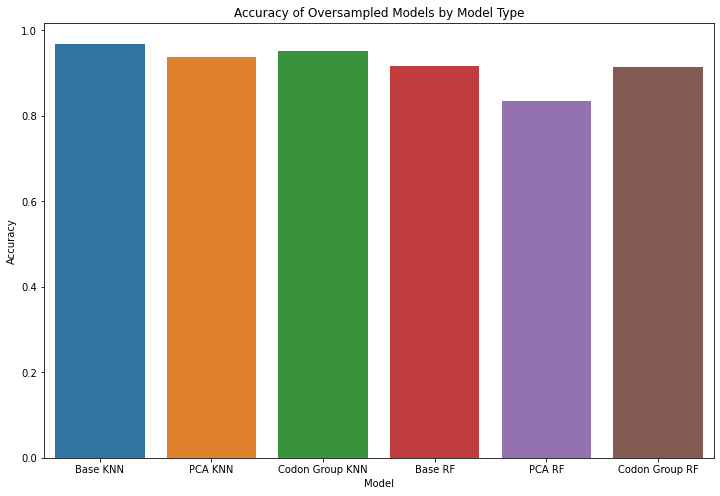

In [26]:
# Graph of accuracies
plt.figure(figsize=(12,8))
sns.barplot(x="Model", y="Accuracy", data=results).set_title("Accuracy of Oversampled Models by Model Type")